In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import scipy.optimize as sco

import random

plt.style.use('fivethirtyeight')
np.random.seed(777)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# selecting stocks into tickers
tickers = ['TSLA', 'AAPL', 'MSFT', 'NVDA', 'AMZN', 'AMD', 'GME']
stocks = yf.download(tickers, period = '2y')['Adj Close']
stocks.head()

[*********************100%***********************]  7 of 7 completed


,AAPL,AMD,AMZN,GME,MSFT,NVDA,TSLA
Date,,,,,,,
2020-12-21,126.708939,93.230003,160.309006,3.8825,218.690521,133.081711,216.619995
2020-12-22,130.315643,93.160004,160.326004,4.8650,220.016876,132.542664,213.446671
2020-12-23,129.406570,91.550003,159.263504,5.1425,217.148026,129.857544,215.326660
2020-12-24,130.404587,91.809998,158.634506,5.0375,218.847717,129.702850,220.589996
2020-12-28,135.068573,91.599998,164.197998,5.2475,221.019028,128.767029,221.229996


In [3]:
# percentage change for stocks
returns = stocks.pct_change()
returns.head()


,AAPL,AMD,AMZN,GME,MSFT,NVDA,TSLA
Date,,,,,,,
2020-12-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-22,0.028464,-0.000751,0.000106,0.253059,0.006065,-0.004050,-0.014649
2020-12-23,-0.006976,-0.017282,-0.006627,0.057040,-0.013039,-0.020259,0.008808
2020-12-24,0.007712,0.002840,-0.003949,-0.020418,0.007827,-0.001191,0.024443
2020-12-28,0.035766,-0.002287,0.035071,0.041687,0.009922,-0.007215,0.002901


In [4]:
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights ) *252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns

In [5]:
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3, num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(7)
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

In [6]:
# inputs for above variables
returns = stocks.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 25000
risk_free_rate = 0.0178

cov_matrix

,AAPL,AMD,AMZN,GME,MSFT,NVDA,TSLA
AAPL,0.000378,0.000409,0.000317,0.000328,0.000276,0.000452,0.000414
AMD,0.000409,0.001093,0.000482,0.000432,0.000391,0.000943,0.000705
AMZN,0.000317,0.000482,0.000610,0.000323,0.000316,0.000556,0.000462
GME,0.000328,0.000432,0.000323,0.016622,0.000238,0.000433,0.000799
MSFT,0.000276,0.000391,0.000316,0.000238,0.000335,0.000455,0.000341
NVDA,0.000452,0.000943,0.000556,0.000433,0.000455,0.001178,0.000747
TSLA,0.000414,0.000705,0.000462,0.000799,0.000341,0.000747,0.001420


In [7]:
def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, weights = random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0, max_sharpe_idx], results[1, max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx], index=stocks.columns, columns= ['allocation'])
    max_sharpe_allocation.allocation = [round(i*100, 2) for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0, min_vol_idx], results[1, min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx], index=stocks.columns, columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100, 2) for i in min_vol_allocation.allocation]
    
    print('-'*80)
    print('Maximum Sharpe Ratio Portfolio Allocation\n')
    print('Annualised Return:', round(rp,2))
    print('Annualised Volatility:', round(rp,2))
    print('\n')
    print(max_sharpe_allocation)
    print('-'*80)
    print('Minimum Volatility Portfolio Allocation\n')
    print('Annualised Return:', round(rp_min,2))
    print('Annualised Volatility:', round(sdp_min,2))
    print('\n')
    print(min_vol_allocation)
    
    plt.figure(figsize=(12, 8))
    plt.scatter(results[0,:],results[1,:],c=results[2,:], cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*', color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp.min,rp_min,marker='*',color='g',s=500, label='Minimum Volatility')
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)
    

In [8]:
#Portfolio frontier is at the bottom

In [9]:
# linear regression
noa = len(tickers)
stocks2 = yf.download(tickers, period = '2y')['Adj Close']
data = stocks2[tickers]
rets = np.log(data / data.shift(1))
#rets.hist(bins=40, figsize=(10, 8));

weights = np.random.random(noa)
weights /= np.sum(weights)

def port_ret(weights):
    return np.sum(rets.mean() * weights) * 252

def port_vol(weights):
    return np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))

[*********************100%***********************]  7 of 7 completed


In [10]:
def min_func_sharpe(weights):
    return -port_ret(weights) / port_vol(weights)

cons = ({'type':'eq', 'fun':lambda x: np.sum(x) - 1})
bnds = tuple((0, 1) for x in range (noa))

In [11]:
eweights = np.array(noa * [1. / noa,])
eweights

array([0.14285714, 0.14285714, 0.14285714, 0.14285714, 0.14285714,
       0.14285714, 0.14285714])

In [12]:
min_func_sharpe(eweights)

-0.09670478970903554

In [13]:
#optimization of function min_func_sharpe
opts = sco.minimize(min_func_sharpe, eweights, method = 'SLSQP', bounds = bnds, constraints = cons)

In [14]:
# minimization of the variance
optv = sco.minimize(port_vol, eweights, method = 'SLSQP', bounds = bnds, constraints = cons)

In [15]:
cons = ({'type': 'eq', 'fun': lambda x: port_ret(x) - tret},
       {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

bnds = tuple((0, 1) for x in weights)


trets = np.linspace(0.05, 0.2, 50)
tvols = []
for tret in trets:
    res = sco.minimize(port_vol, eweights, method = 'SLSQP', 
                      bounds = bnds, constraints = cons)
    tvols.append(res['fun'])
tvols = np.array(tvols)


In [16]:
prets = []
pvols = []
for p in range (2500):
    weights = np.random.random(noa)
    weights /= np.sum(weights)
    prets.append(port_ret(weights))
    pvols.append(port_vol(weights))
prets = np.array(prets)
pvols = np.array(pvols)

C:\Users\lakhv\AppData\Local\Temp/ipykernel_19536/429366200.py:9: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(label = 'Sharpe Ratio')


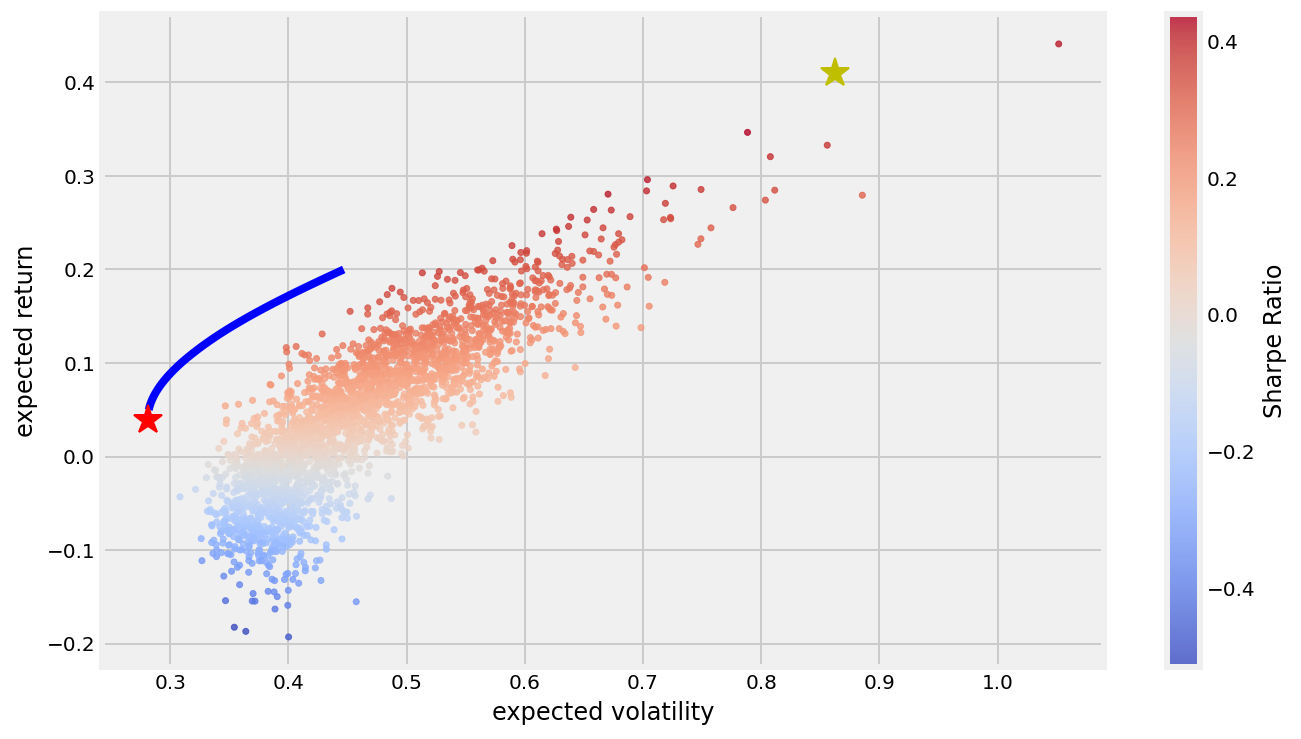

In [17]:
plt.figure(figsize=(10, 6))
plt.scatter(pvols, prets, c=prets / pvols,
           marker = '.', alpha = 0.8, cmap='coolwarm')
plt.plot(tvols, trets, 'b', lw=4.0)
plt.plot(port_vol(opts['x']), port_ret(opts['x']), 'y*', markersize=15.0)  
plt.plot(port_vol(optv['x']), port_ret(optv['x']), 'r*', markersize=15.0)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label = 'Sharpe Ratio')

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 1.06
Annualised Volatility: 1.06


            AAPL   AMD  AMZN    GME   MSFT   NVDA  TSLA
allocation  0.93  0.41  2.65  38.84  32.44  21.97  2.76
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.08
Annualised Volatility: 0.3


      allocation
AAPL       40.41
AMD         6.10
AMZN       15.10
GME         2.28
MSFT       31.22
NVDA        2.90
TSLA        1.98


C:\Users\lakhv\AppData\Local\Temp/ipykernel_19536/914192113.py:30: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar()


TypeError: float() argument must be a string or a number, not 'builtin_function_or_method'

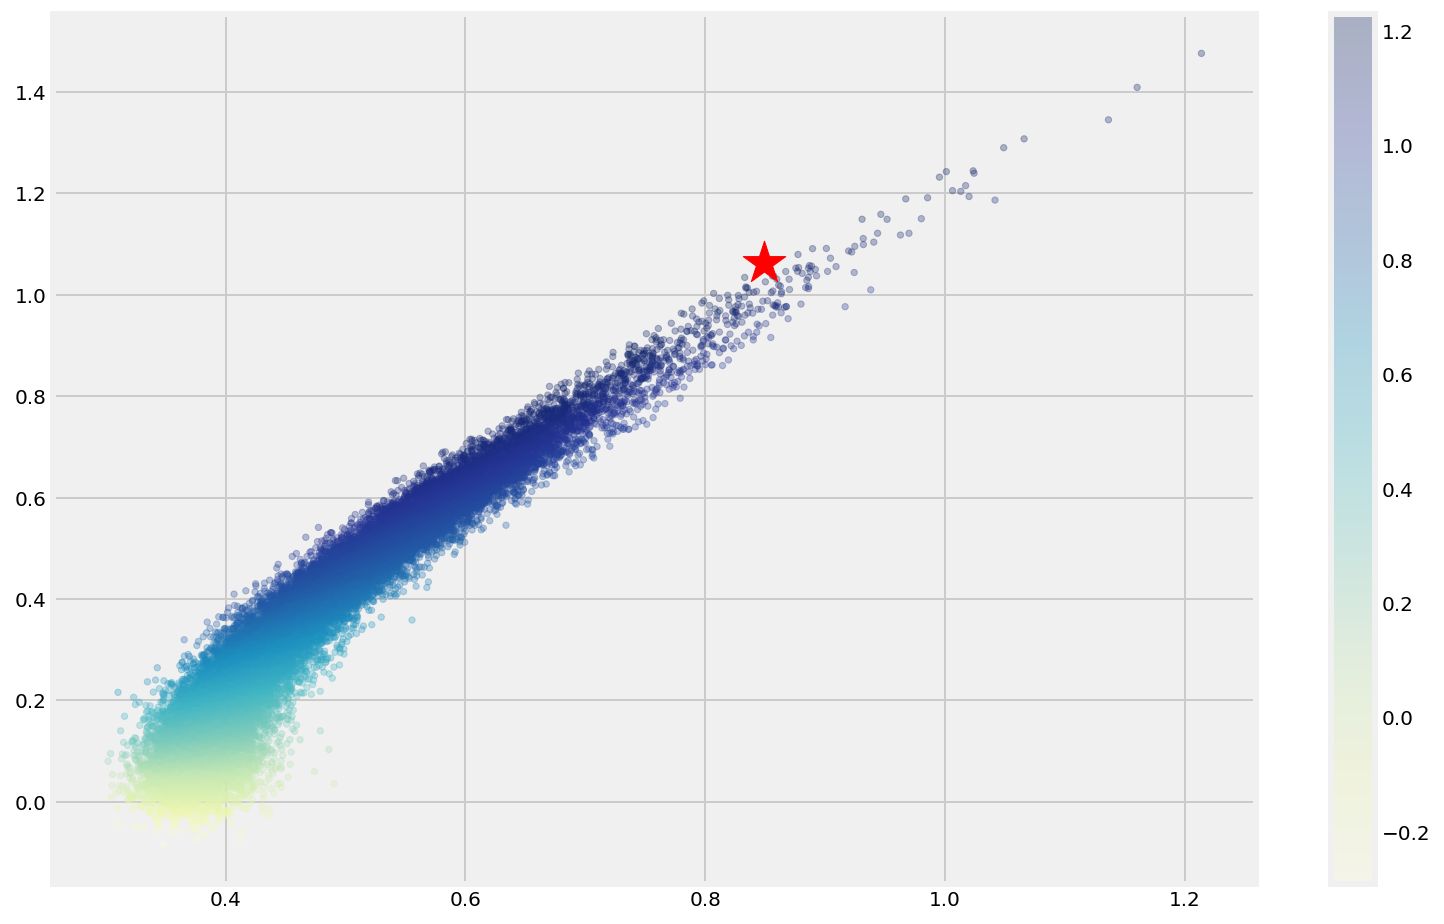

In [18]:
display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate) # Monte carlo method

In [ ]:
# sources
# https://towardsdatascience.com/efficient-frontier-portfolio-optimisation-in-python-e7844051e7f 
# Python for Finance Textbook by Yves Hilpisch
